# About Data
Data terdiri dari informasi bangunan di wilayah yang terkena gempa yang digunakan untuk babak penyisihan JOINTS UGM 2023

Dataset terdiri dari beberapa kolom diantaranya :
1. floors_before_eq (total) : jumlah total lantai pada bangunan sebelum gempa terjadi
2. old_building : usia bangunan (tahun)
3. plinth_area (ft^2) : luas bangunan (ft^2)
4. height_before_eq (ft) : tinggi bangunan sebelum terjadi gempa (kaki)
5. land_surface_condition : kondisi permukaan tanah disaat bangunan akan dibangun
6. type_of_foundation : jenis fondasi yang dipakai untuk bangunan tsb
7. type_of_roof : jenis atap yang dipakai untuk bangunan tsb
8. type_of_ground_floor : jenis lantai yang dipakai untuk ground-floor
9. type_of_other_floor : jenis lantai yang dipakai untuk selain ground-floor
10. position : Posisi bangunan tersebut apakah bersisian secara langsung dengan bangunan lain
11. building_plan_configuration : konfigurasi bangunan yang berkaitan dengan bentuk, ukuran, dan penempatan struktur utama bangunan
12. technical_solution_proposed : Solusi yang ditawarkan untuk bangunan yang terdampak gempa
13. legal_ownership_status : Status kepemilikan bangunan
14. has_secondary_use : Keterangan apakah bangunan memiliki kegunaan sekunder
15. type_of_reinforcement_concrete : Tipe beton bertulang/reinforcement concrete
16. residential_type : Tipe penggunaaan sebagai hunian
17. no_family_residing : Jumlah keluarga yang tinggal dalam bangunan tersebut
18. public_place_type : Tipe penggunaan sebagai tempat umum
19. industrial_use_type : Tipe industri
20. govermental_use_type : Tipe penggunaan sebagai bangunan pemerintahan
21. flexible_superstructure : Keterangan penggunaan superstructure yang fleksibel
22. wall_binding : Material yang digunakan sebagai perekat bahan pembentuk dinding
23. wall_material : Material dasar sebagai pembangun dinding
24. damage_grade (variabel target) : Tingkat kerusakan yang disebabkan oleh gempa (1-5)

Hal ini ditambah dengan beberapa penjelasan fitur :

type_of_reinforcement_concrete
- 0 : Unknown/not stated
- 1 : Clay
- 2 : Mortar + Cement
- 3 : Mortar + Cement, Clay
- 5 : Mud + Mortar, Clay
- 7 : Mud + Mortar, Clay, Cement + Mortar

wall_material
- 0 : Unknown/not stated
- 1 : Red Bricks
- 2 : Stone Bricks
- 3 : Red Bricks, Stone Bricks

type_of_reinforcement_concrete
- 0 : No reinforcement concrete
- 1 : Has non-engineered reinforcement concrete
- 2 : Has engineered reinforcement concrete
- 3 : Has both

# Tujuan
Menganalisis karakteristik bangunan yang memiliki tingkat kerusakan yang rendah

# Import

In [447]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, RobustScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold, cross_val_score, GridSearchCV
from scipy.stats import chi2_contingency
from sklearn.feature_selection import VarianceThreshold

# models
import optuna
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier

# metric used for the competition
from sklearn.metrics import f1_score

# Analisis Sekilas Data

In [448]:
path = "..\\Datasets\\train.csv.zip"
df = pd.read_csv(path,compression="zip", index_col = "Unnamed: 0")
df = df.sort_index()
df = df.reset_index(drop=True)

test_path = "..\\Datasets\\test.csv.zip"
test = pd.read_csv(test_path,compression="zip", index_col='id')
test = test.sort_index()
test = test.reset_index(drop=True)

df.head()

d:\Anaconda\lib\site-packages\IPython\core\interactiveshell.py:3444: DtypeWarning: Columns (1,3,5,6,7,8,9,10,11,12,13,16,17,19,20) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


,floors_before_eq (total),old_building,plinth_area (ft^2),height_before_eq (ft),land_surface_condition,type_of_foundation,type_of_roof,type_of_ground_floor,type_of_other_floor,position,...,type_of_reinforcement_concrete,residential_type,no_family_residing,public_place_type,industrial_use_type,govermental_use_type,flexible_superstructure,wall_binding,wall_material,damage_grade
0,floor two,1.0,256 ft^2,22.0,Flat,Bamboo or Timber,Bamboo/Timber Light roof,Clay,TImber/Bamboo-Mud,Not attached,...,0.0,Non-residential,1.0,Non-public,Non-industrial,Non-govermental,unavailable,0.0,0.0,1.0
1,Floor 3,3.0,985 ft^2,18.0,Flat,Clay Sand Mixed mortar-Stone/Brick,Wood Light Roof or Bamboo Heavy Roof,Clay,TImber/Bamboo-Mud,Not attached,...,0.0,Non-residential,1.0,Non-public,Non-industrial,Non-govermental,unavailable,5.0,2.0,5.0
2,Two Floor,7.0,NaN,14.0,Flat,Mud mortar-Stone/Brick,NaN,Clay,Wood-Mud or Bamboo Mud,Not attached,...,0.0,Non-residential,1.0,Non-public,Non-industrial,Non-govermental,unavailable,5.0,2.0,5.0
3,Two Floor,7.0,NaN,14.0,Flat,Mud mortar-Stone/Brick,NaN,Clay,Wood-Mud or Bamboo Mud,Not attached,...,0.0,Non-residential,1.0,Non-public,Non-industrial,Non-govermental,unavailable,5.0,2.0,5.0
4,two,18.0,185 ft^2,15.0,Flat,Clay Sand Mixed mortar-Stone/Brick,Wood Light Roof or Bamboo Light Roof,Clay,TImber/Bamboo-Mud,Not attached,...,0.0,Non-residential,1.0,Non-public,Non-industrial,Non-govermental,unavailable,5.0,2.0,4.0


In [449]:
test['type_of_ground_floor'].unique()

array(['Clay', 'Brick or Stone', 'mud', 'RC', 'Mud',
       'reinforced concrete', 'Brick/Stone', 'Reinforced Concrete',
       'soil, water, loam Mixed', 'Other', 'Lumber', 'brick/stone',
       'TImber', 'Wood', 'Timber'], dtype=object)

In [450]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 722815 entries, 0 to 722814
Data columns (total 24 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   floors_before_eq (total)        390009 non-null  object 
 1   old_building                    483611 non-null  float64
 2   plinth_area (ft^2)              301607 non-null  object 
 3   height_before_eq (ft)           390009 non-null  float64
 4   land_surface_condition          421209 non-null  object 
 5   type_of_foundation              483611 non-null  object 
 6   type_of_roof                    301607 non-null  object 
 7   type_of_ground_floor            390009 non-null  object 
 8   type_of_other_floor             421209 non-null  object 
 9   position                        410809 non-null  object 
 10  building_plan_configuration     421209 non-null  object 
 11  technical_solution_proposed     46801 non-null   object 
 12  legal_ownership_

### Terlihat beberapa missing value pada data, berikut adalah jumlah untuk setiap fitur

In [451]:
df.isna().sum()

floors_before_eq (total)          332806
old_building                      239204
plinth_area (ft^2)                421208
height_before_eq (ft)             332806
land_surface_condition            301606
type_of_foundation                239204
type_of_roof                      421208
type_of_ground_floor              332806
type_of_other_floor               301606
position                          312006
building_plan_configuration       301606
technical_solution_proposed       676014
legal_ownership_status            124802
has_secondary_use                 197604
type_of_reinforcement_concrete    291206
residential_type                  270404
no_family_residing                145602
public_place_type                      0
industrial_use_type               114402
govermental_use_type              249604
flexible_superstructure            62400
wall_binding                       62400
wall_material                     228804
damage_grade                           0
dtype: int64

Berikut adalah jumlah duplicated values

In [452]:
print(len(df)-len(df.drop_duplicates().dropna()))

676016


Berikut adalah jumlah data apabila seluruh nilai duplikat dan missing value dihilangkan

In [453]:
len(df.dropna().drop_duplicates())

46799

In [454]:
(len(df.dropna().drop_duplicates())/len(df)) * 100

6.474547429148537

Maka jumlah data yang tersisa hanya 6% dari data asli, jika missing value dihilangkan secara langsung, maka akan banyak informasi yang hilang, sehingga mari kita analisis lebih lanjut untuk menentukan apakah data perlu dilakukan drop missing value

### Handling Missing Value

Kita dapat menvisualisasikan missing value dengan library missingno sehingga lebih mudah dilihat

<AxesSubplot:>

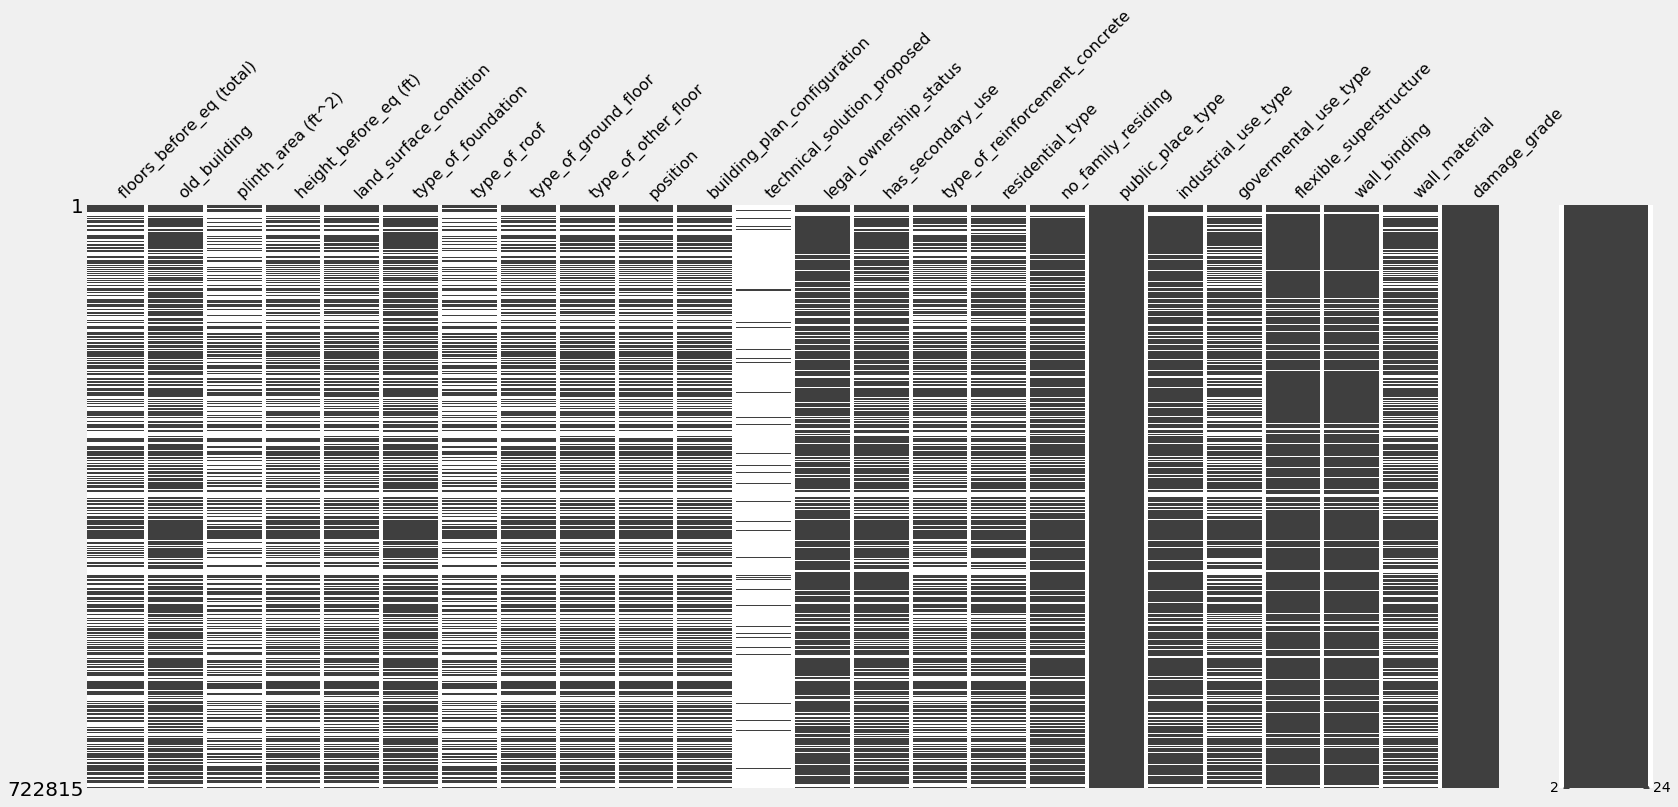

In [455]:
import missingno as msno
msno.matrix(df)

Terlihat bahwa penyebab informasi hilang terbanyak terdapat pada fitur technical_solution_proposed

Untuk melihat korelasi antara nilai yang hilang, kita dapat menggunakan heatmap dari missingno

<AxesSubplot:>

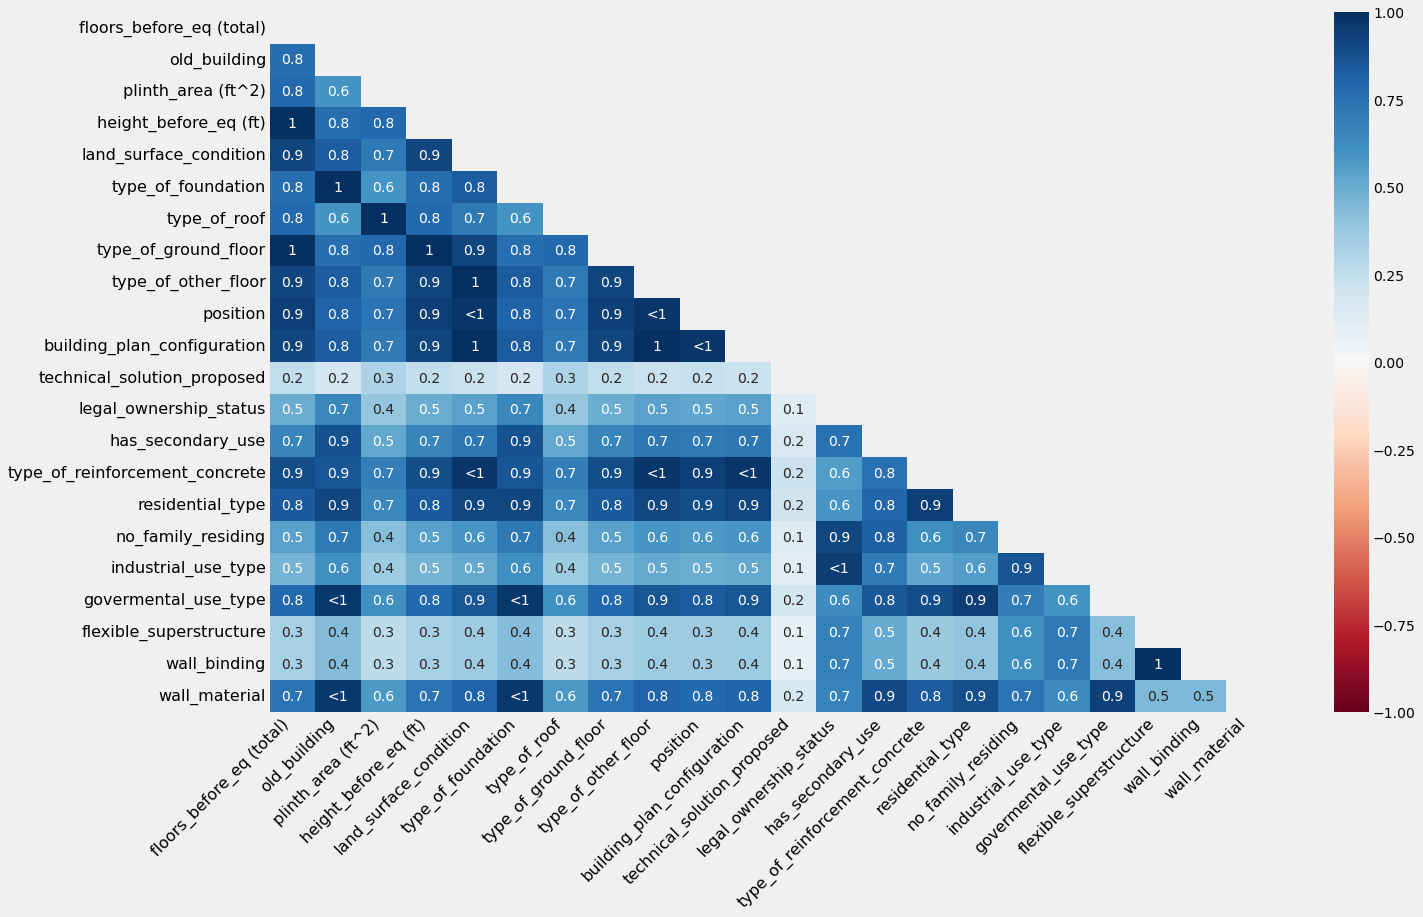

In [456]:
msno.heatmap(df)

Kita dapat melihat bahwa technical_solution_proposed memiliki ketergantungan nilai hilang yang sangat rendah dengan fitur lain, namun sesuai dengan deskripsi fitur, fitur ini adalah rekomendasi solusi terhadap bangunan yang rusak, yang seharusnya juga memiliki ikatan dengan damage_grade. 

Mari kita lihat lebih lanjut apakah isi technical_solution_proposed sesuai dengan damage grade

In [457]:
solution = df['technical_solution_proposed'].unique()[1:]
solution = ['No need', 'Minor repair', 'Major repair', 'Reconstruction']
list_sol = []
for sol in solution :
    list_sol.append([sol])

count = 0
for sol in solution :
    for damage in range(1,6,1) :
        damage_count = len(df[(df['technical_solution_proposed'] == sol) & (df['damage_grade'] == damage)][['technical_solution_proposed', 'damage_grade']])
        list_sol[count].append(damage_count)
    count += 1

df_sol = pd.DataFrame(list_sol, columns=['Solution','Grade 1','Grade 2','Grade 3', 'Grade 4', 'Grade 5'])

In [458]:
df_sol

,Solution,Grade 1,Grade 2,Grade 3,Grade 4,Grade 5
0,No need,3106,30,3,0,0
1,Minor repair,1701,4534,598,16,3
2,Major repair,25,600,6293,1042,3
3,Reconstruction,9,149,1554,10176,16959


Terlihat beberapa solution tidak sesuai dengan damage, mari kita visualisasikan sehingga dapat terlihat lebih jelas

Text(0.5, 0, '')

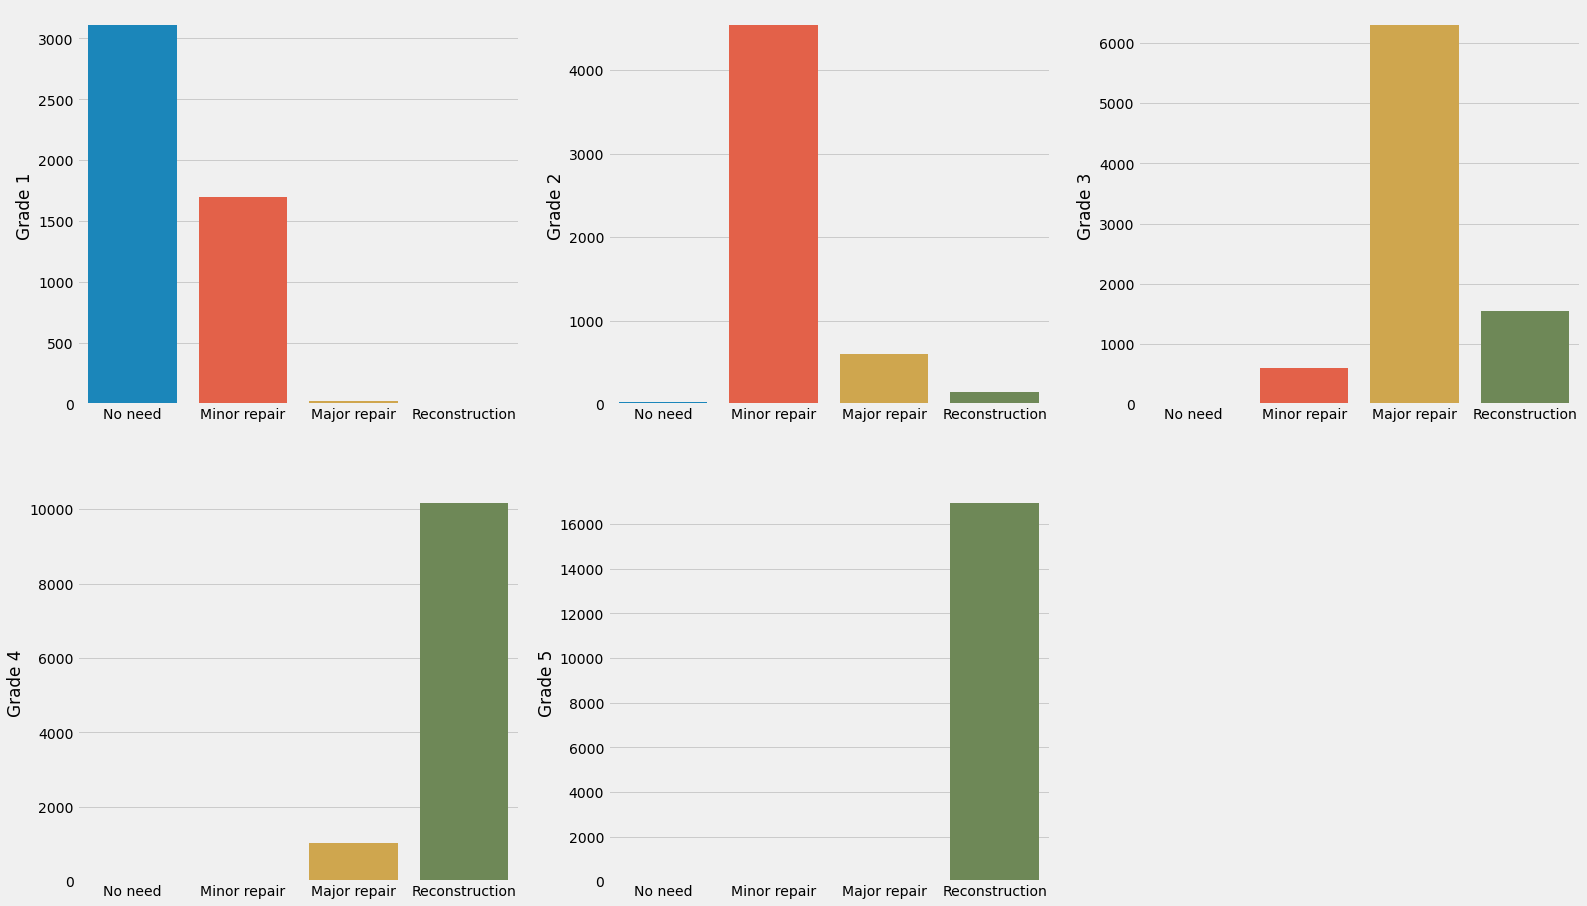

In [459]:
plt.figure(figsize=(24,15))
plt.style.use('fivethirtyeight')

plt.subplot(2,3,1)
sns.barplot(x=df_sol['Solution'],y=df_sol['Grade 1'])
plt.xlabel('')

plt.subplot(2,3,2)
sns.barplot(x=df_sol['Solution'],y=df_sol['Grade 2'])
plt.xlabel('')

plt.subplot(2,3,3)
sns.barplot(x=df_sol['Solution'],y=df_sol['Grade 3'])
plt.xlabel('')

plt.subplot(2,3,4)
sns.barplot(x=df_sol['Solution'],y=df_sol['Grade 4'])
plt.xlabel('')

plt.subplot(2,3,5)
sns.barplot(x=df_sol['Solution'],y=df_sol['Grade 5'])
plt.xlabel('')

Dari visualisasi ini, kita dapat menyimpulkan bahwa sebagian besar dari solusi teknis yang diberikan sesuai dengan tingkat kerusakan bangunan, sehingga kita dapat menambah beberapa pertimbangan dalam EDA dan Modelling :

1. Dikarenakan technical_solution_proposed berpengaruh terhadap variabel target meskipun data akan hanya tersisa 6%, maka modelling akan diujicoba tanpa dan dengan fitur technical_solution_proposed
2. EDA akan dilakukan dengan melakukan drop kolom technical_solution_proposed kemudian melakukan dropna sehingga data yang hilang tidak begitu signifikan. Meskipun fitur tersebut berhubungan dengan grade damage, namun tidak relevan dengan tujuan EDA yaitu menganalisis karakterisitk bangunan yang memiliki tingkat kerusakan kecil

Selanjutnya, kita akan memerika distribusi class apabila dilakukan drop missing value dan tidak

Text(0.5, 1.0, 'Original Data')

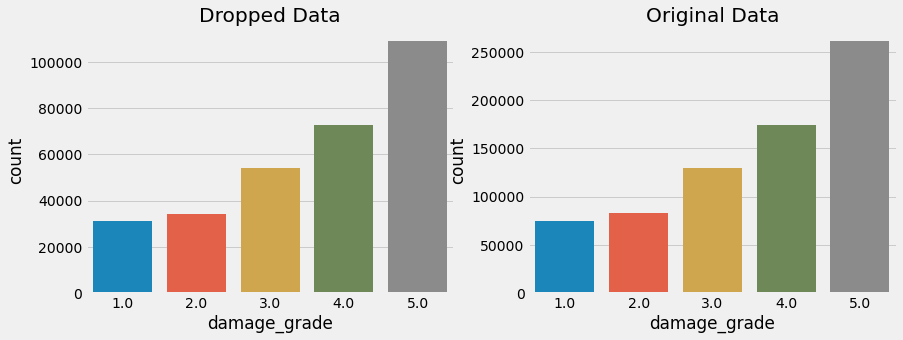

In [460]:
plt.figure(figsize=(20,10))
plt.style.use('fivethirtyeight')
df_dropped_na = df.drop('technical_solution_proposed', axis=1)
df_dropped_na = df_dropped_na.dropna()

plt.subplot(2,3,1)
sns.countplot(x=df_dropped_na['damage_grade'])
plt.title('Dropped Data')

plt.subplot(2,3,2)
sns.countplot(x=df['damage_grade'])
plt.title('Original Data')

Tidak ada perubahan yang signifikan dari kedua tipe data, oleh karena itu, data yang dilakukan drop akan diprioritaskan

### Preprocessing

In [461]:
df_dropped_na = df.copy()

discrete = ['wall_binding', 'type_of_reinforcement_concrete', 'wall_material']
TARGET = 'damage_grade'
df_dropped_na[discrete] = df_dropped_na[discrete].applymap(lambda x: str(x) if not pd.isna(x) else x)
test[discrete] = test[discrete].applymap(lambda x: str(x) if not pd.isna(x) else x)

df_dropped_na['public_place_type'] = df_dropped_na['public_place_type'].apply(lambda x : 'Public' if x != 'Non-public' else x)
df_dropped_na['technical_solution_proposed'] = df_dropped_na['technical_solution_proposed'].fillna(df_dropped_na.groupby(['public_place_type', 'damage_grade'])['technical_solution_proposed'].transform(lambda x: x.mode().values[0] if not x.mode().empty else None))
df_dropped_na['wall_binding'] = df_dropped_na['wall_binding'].fillna(df_dropped_na.groupby(['public_place_type', 'damage_grade'])['wall_binding'].transform(lambda x: x.mode().values[0] if not x.mode().empty else None))
df_dropped_na['type_of_reinforcement_concrete'] = df_dropped_na['type_of_reinforcement_concrete'].fillna(df_dropped_na.groupby(['public_place_type', 'damage_grade'])['type_of_reinforcement_concrete'].transform(lambda x: x.mode().values[0] if not x.mode().empty else None))
df_dropped_na['wall_material'] = df_dropped_na['wall_material'].fillna(df_dropped_na.groupby(['public_place_type', 'damage_grade'])['wall_material'].transform(lambda x: x.mode().values[0] if not x.mode().empty else None))

# Impute missing values with mode for categorical columns
categorical_cols = df_dropped_na.select_dtypes(include='object').columns  # Get the column names of categorical columns
df_dropped_na[categorical_cols] = df_dropped_na[categorical_cols].fillna(df_dropped_na.groupby(['public_place_type', 'damage_grade'])[categorical_cols].transform(lambda x: x.mode().values[0] if not x.mode().empty else None))

# Impute missing values with median for numerical columns
numerical_cols = df_dropped_na.select_dtypes(include='number').columns  # Get the column names of numerical columns

# Define a custom function to fill missing values with median, handling empty median case
def fillna_with_median(x):
    median = x.mean()
    if pd.isna(median):
        return None  # or any other appropriate value
    else:
        return median

# Fill missing values with median based on 'public_place_type' and 'damage_grade'
df_dropped_na[numerical_cols] = df_dropped_na[numerical_cols].fillna(df_dropped_na.groupby(['public_place_type', 'damage_grade'])[numerical_cols].transform(fillna_with_median))

In [462]:
df_dropped_na['wall_binding'].unique()

array(['0.0', '5.0', '2.0', '1.0', '7.0', '3.0'], dtype=object)

In [463]:
test['public_place_type'] = test['public_place_type'].apply(lambda x : 'Public' if x != 'Non-public' else x)

Selanjutnya adalah melakukan pembersihan data untuk dilakukan analisis lebih lanjut, pembersihan data pertama tama akan dilakukan pada kolom kategorikal

Beberapa fitur memiliki nilai problematik dengan delimiter dan case yang berbeda beda :
1. floors_before_eq (total)
2. type_of_foundation
3. type_of_roof
4. type_of_ground_floor
5. type_of_other_floor
6. legal_ownership_status

Pertama yang akan dibersihkan adalah fitur floors_before_eq, nilai teks akan diubah menjadi angka

In [464]:
def transform_floors_before_eq(value):
    if isinstance(value, str):
        value = value.lower()
        if any(x in value for x in ['one','first','1']) :
            return 1
        elif any(x in value for x in ['two','second','2']) :
            return 2
        elif any(x in value for x in ['three','third','3','3.00']) :
            return 3
        elif any (x in value for x in ['four','fourth','4']) :
            return 4
        elif any (x in value for x in ['five','fifth','5']) :
            return 5
        else :
            return value
    else :
        return value


df_dropped_na['floors_before_eq (total)'] = df_dropped_na['floors_before_eq (total)'].apply(lambda x : transform_floors_before_eq(x))

test['floors_before_eq (total)'] = test['floors_before_eq (total)'].apply(lambda x : transform_floors_before_eq(x))

df_dropped_na['floors_before_eq (total)'].head()

0    2
1    3
2    2
3    2
4    2
Name: floors_before_eq (total), dtype: object

Kemudian, kita melakukan pembersihan pada type_x

In [465]:
df_dropped_na['type_of_foundation'] = df_dropped_na['type_of_foundation'].replace({
    'Cement-Stone or Cement-Brick' : 'Cement-Stone/Brick',
    'Bamboo or Timber' : 'Bamboo/Timber',
    'RC' : 'Reinforced Concrete',
    'Bamboo/TImber' : 'Bamboo/Timber',
    'Others' : 'Other'
    })

test['type_of_foundation'] = test['type_of_foundation'].replace({
    'Cement-Stone or Cement-Brick' : 'Cement-Stone/Brick',
    'Bamboo or Timber' : 'Bamboo/Timber',
    'RC' : 'Reinforced Concrete',
    'Bamboo/TImber' : 'Bamboo/Timber',
    'Others' : 'Other'
    })

df_dropped_na['type_of_foundation'].unique()

array(['Bamboo/Timber', 'Clay Sand Mixed mortar-Stone/Brick',
       'Mud mortar-Stone/Brick', 'Clay mortar-Stone/Brick',
       'Reinforced Concrete', 'Cement-Stone/Brick', 'Other'], dtype=object)

In [466]:
df_dropped_na['type_of_roof'] = df_dropped_na['type_of_roof'].replace({
    'Bamboo or Timber-Light roof' : 'Bamboo/Timber Light roof',
    'Bamboo or Timber Light roof' : 'Bamboo/Timber Light roof',
    'Bamboo or Timber Heavy roof' : 'Bamboo/Timber Heavy roof',
    'Wood Light Roof or Bamboo Light Roof' : 'Wood Light roof/Bamboo Light roof',
    'Wood Light Roof or Bamboo Heavy Roof' : 'Wood Light roof/Bamboo Heavy roof',
    'Bamboo/TImber-Light Roof' : 'Bamboo/Timber Light roof',
    'reinforced cement concrete/rb/rbc' : 'rcc/rb/rbc',
    'Reinforced Brick Slab/rcc/rbc' : 'rbs/rcc/rbc',
    'Bamboo/TImber-Heavy Roof' : 'Bamboo/Timber Heavy roof',
    'Bamboo or Timber Heavy Roof' : 'Bamboo/Timber Heavy roof',
    'Reinforced brick concrete/rcc/rbc' : 'rb/rbc'
})

test['type_of_roof'] = test['type_of_roof'].replace({
    'Bamboo or Timber-Light roof' : 'Bamboo/Timber Light roof',
    'Bamboo or Timber Light roof' : 'Bamboo/Timber Light roof',
    'Bamboo or Timber Heavy roof' : 'Bamboo/Timber Heavy roof',
    'Wood Light Roof or Bamboo Light Roof' : 'Wood Light roof/Bamboo Light roof',
    'Wood Light Roof or Bamboo Heavy Roof' : 'Wood Light roof/Bamboo Heavy roof',
    'Bamboo/TImber-Light Roof' : 'Bamboo/Timber Light roof',
    'reinforced cement concrete/rb/rbc' : 'rcc/rb/rbc',
    'Reinforced Brick Slab/rcc/rbc' : 'rbs/rcc/rbc',
    'Bamboo/TImber-Heavy Roof' : 'Bamboo/Timber Heavy roof',
    'Bamboo or Timber Heavy Roof' : 'Bamboo/Timber Heavy roof',
    'Reinforced brick concrete/rcc/rbc' : 'rb/rbc'
})

df_dropped_na['type_of_roof'].unique()

array(['Bamboo/Timber Light roof', 'Wood Light roof/Bamboo Heavy roof',
       'Wood Light roof/Bamboo Light roof', 'rbs/rcc/rbc',
       'Bamboo/Timber Heavy roof', 'rcc/rb/rbc', 'rb/rbc'], dtype=object)

In [467]:
df_dropped_na['type_of_ground_floor'] = df_dropped_na['type_of_ground_floor'].replace({
    'mud' : 'Mud',
    'Brick or Stone' : 'Brick/Stone',
    'reinforced concrete' : 'Reinforced Concrete',
    'RC' : 'Reinforced Concrete',
    'brick/stone' : 'Brick/Stone',
    'TImber' : 'Timber',
    'soil, water, loan Mixed' : 'soil, water, loam Mixed'
})

test['type_of_ground_floor'] = test['type_of_ground_floor'].replace({
    'mud' : 'Mud',
    'Brick or Stone' : 'Brick/Stone',
    'reinforced concrete' : 'Reinforced Concrete',
    'RC' : 'Reinforced Concrete',
    'brick/stone' : 'Brick/Stone',
    'TImber' : 'Timber'
})

df_dropped_na['type_of_ground_floor'].unique()

array(['Clay', 'Mud', 'Brick/Stone', 'Reinforced Concrete',
       'soil, water, loam Mixed', 'Other', 'Lumber', 'Timber', 'Wood'],
      dtype=object)

In [468]:
df_dropped_na['type_of_other_floor'] = df_dropped_na['type_of_other_floor'].replace({
    'Timber-Planck' : 'Timber-Plank',
    'TImber/Bamboo-Mud' : 'Timber/Bamboo-Mud',
    'Timber Mud or Bamboo-Mud' : 'Timber Mud/Bamboo-Mud',
    'Wood or Bamboo Mud' : 'Wood/Bamboo-Mud',
    'Wood-Mud or Bamboo Mud' : 'Wood-Mud/Bamboo Mud',
    'Reinforced brick concrete/rcc/rbc' : 'rcc/rbc',
    'reinforced cement concrete/rb/rbc' : 'rcc/rb/rbc'
})

test['type_of_other_floor'] = test['type_of_other_floor'].replace({
    'Timber-Planck' : 'Timber-Plank',
    'TImber/Bamboo-Mud' : 'Timber/Bamboo-Mud',
    'Timber Mud or Bamboo-Mud' : 'Timber Mud/Bamboo-Mud',
    'Wood or Bamboo Mud' : 'Wood/Bamboo-Mud',
    'Wood-Mud or Bamboo Mud' : 'Wood-Mud/Bamboo Mud',
    'Reinforced brick concrete/rcc/rbc' : 'rcc/rbc',
    'reinforced cement concrete/rb/rbc' : 'rcc/rb/rbc'
})

df_dropped_na['type_of_other_floor'].unique()

array(['Timber/Bamboo-Mud', 'Wood-Mud/Bamboo Mud',
       'Timber Mud/Bamboo-Mud', 'Not applicable', 'Wood/Bamboo-Mud',
       'rcc/rb/rbc', 'Wood-Plank', 'Timber-Plank', 'Lumber-plank',
       'rcc/rbc'], dtype=object)

Kemudian, dilakukan pembersihan pada legal_ownership_status dan plinth_area

In [469]:
def transform_use(x) :
    if x == 'Private Use' or x == 'Private' or x == 'Prvt' or x == 'Privste' :
        return 'private'
    elif x == 'Public' or x =='Public Space' or x == 'Public Use' :
        return 'public'
    elif x == 'Unknown' or x == 'Unspecified' or x == 'Other' :
        return 'other'
    elif x == 'Institutional Use' or x == 'Institutionals' or x == 'Institutional' :
        return 'institutional'

df_dropped_na['legal_ownership_status'] = df_dropped_na['legal_ownership_status'].apply(lambda x : transform_use(x))
test['legal_ownership_status'] = test['legal_ownership_status'].apply(lambda x : transform_use(x))

In [470]:
df_dropped_na['plinth_area (ft^2)'] = df_dropped_na['plinth_area (ft^2)'].apply(lambda x : x.split(" ")[0] if x != "More than 1000 ft^2" else x.split(" ")[-2])
df_dropped_na['plinth_area (ft^2)'] = pd.to_numeric(df_dropped_na['plinth_area (ft^2)'])

test['plinth_area (ft^2)'] = test['plinth_area (ft^2)'].apply(lambda x : x.split(" ")[0] if x != "More than 1000 ft^2" else x.split(" ")[-2])
test['plinth_area (ft^2)'] = pd.to_numeric(test['plinth_area (ft^2)'])

In [471]:
df_dropped_na['height_before_eq (ft)'] = pd.to_numeric(df_dropped_na['height_before_eq (ft)'], errors='coerce')
df_dropped_na['floors_before_eq (total)'] = pd.to_numeric(df_dropped_na['floors_before_eq (total)'], errors='coerce')

test['height_before_eq (ft)'] = pd.to_numeric(test['height_before_eq (ft)'], errors='coerce')
test['floors_before_eq (total)'] = pd.to_numeric(test['floors_before_eq (total)'], errors='coerce')


In [472]:
df_dropped_na['volume'] = df_dropped_na['plinth_area (ft^2)'] * df_dropped_na['height_before_eq (ft)']
df_dropped_na['heightPerFloor'] = df_dropped_na['height_before_eq (ft)'] / df_dropped_na['floors_before_eq (total)']

test['volume'] = test['plinth_area (ft^2)'] * test['height_before_eq (ft)']
test['heightPerFloor'] = test['height_before_eq (ft)'] / test['floors_before_eq (total)']

In [473]:
df_dropped_na['no_family_residing'] = df_dropped_na['no_family_residing'].apply(lambda x: int(float(x)) if x != 'None' else 0)

test['no_family_residing'] = test['no_family_residing'].apply(lambda x: int(float(x)) if x != 'None' else 0)

In [474]:
df_dropped_na['type_of_foundation'] = df_dropped_na['type_of_foundation'].apply(lambda x: 'mortar-Stone/Brick' if 'mortar-Stone/Brick' in x else x)
test['type_of_foundation'] = test['type_of_foundation'].apply(lambda x: 'mortar-Stone/Brick' if 'mortar-Stone/Brick' in x else x)

### Log Transform

In [475]:
df_dropped_na['volume'] = np.sqrt(df_dropped_na['volume'])
df_dropped_na['heightPerFloor'] = np.sqrt(df_dropped_na['heightPerFloor'])
df_dropped_na['floors_before_eq (total)'] = np.sqrt(df_dropped_na['floors_before_eq (total)'])

test['volume'] = np.sqrt(test['volume'])
test['heightPerFloor'] = np.sqrt(test['heightPerFloor'])
test['floors_before_eq (total)'] = np.sqrt(test['floors_before_eq (total)'])

In [476]:
# df_dropped_na[['type_of_foundation','type_of_roof','type_of_ground_floor','type_of_other_floor','type_of_reinforcement_concrete','wall_binding','wall_material']].to_csv('building_materials.csv')

In [477]:
# materials_pisah = pd.read_csv('materials_pisah.csv', index_col='Unnamed: 0')

# df_dropped_na = df_dropped_na.drop(['type_of_foundation','type_of_roof','type_of_ground_floor','type_of_other_floor','type_of_reinforcement_concrete','wall_binding','wall_material'], axis=1)

# df_dropped_na = pd.concat([materials_pisah, df_dropped_na], axis=1)

## Scalling, Hyperparam, & Model

In [478]:
scaler3 = MinMaxScaler()

data_num = df_dropped_na.select_dtypes(include='number').drop(TARGET, axis=1)
data_num['old_building'] = scaler3.fit_transform(data_num['old_building'].to_numpy().reshape(-1,1))
data_num['plinth_area (ft^2)'] = scaler3.fit_transform(data_num['plinth_area (ft^2)'].to_numpy().reshape(-1,1))
data_num['volume'] = scaler3.fit_transform(data_num['volume'].to_numpy().reshape(-1,1))
data_num['heightPerFloor'] = scaler3.fit_transform(data_num['heightPerFloor'].to_numpy().reshape(-1,1))
data_num['height_before_eq (ft)'] = scaler3.fit_transform(data_num['height_before_eq (ft)'].to_numpy().reshape(-1,1))
data_num['floors_before_eq (total)'] = scaler3.fit_transform(data_num['floors_before_eq (total)'].to_numpy().reshape(-1,1))

data_cat = df_dropped_na.select_dtypes('object')
encoder = OneHotEncoder(drop='first')
concat = pd.concat([data_num, pd.DataFrame(encoder.fit_transform(data_cat).toarray(), columns=encoder.get_feature_names(data_cat.columns)), df_dropped_na[TARGET]], axis=1)

In [479]:
test['type_of_reinforcement_concrete'] = test['type_of_reinforcement_concrete'].apply(lambda x: str(float(x)))
test['wall_binding'] = test['wall_binding'].apply(lambda x: str(float(x)))
test['wall_material'] = test['wall_material'].apply(lambda x: str(float(x)))

In [480]:
test_num = test.select_dtypes(include='number')
test_num['old_building'] = scaler3.fit_transform(test_num['old_building'].to_numpy().reshape(-1,1))
test_num['plinth_area (ft^2)'] = scaler3.fit_transform(test_num['plinth_area (ft^2)'].to_numpy().reshape(-1,1))
test_num['volume'] = scaler3.fit_transform(test_num['volume'].to_numpy().reshape(-1,1))
test_num['heightPerFloor'] = scaler3.fit_transform(test_num['heightPerFloor'].to_numpy().reshape(-1,1))
test_num['height_before_eq (ft)'] = scaler3.fit_transform(test_num['height_before_eq (ft)'].to_numpy().reshape(-1,1))
test_num['floors_before_eq (total)'] = scaler3.fit_transform(test_num['floors_before_eq (total)'].to_numpy().reshape(-1,1))

test_cat = test.select_dtypes('object')
test_concat = pd.concat([test_num, pd.DataFrame(encoder.fit_transform(test_cat).toarray(), columns=encoder.get_feature_names(test_cat.columns))], axis=1)
test_concat

C:\Users\Rangga\AppData\Local\Temp/ipykernel_9500/1952177371.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_num['old_building'] = scaler3.fit_transform(test_num['old_building'].to_numpy().reshape(-1,1))
C:\Users\Rangga\AppData\Local\Temp/ipykernel_9500/1952177371.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_num['plinth_area (ft^2)'] = scaler3.fit_transform(test_num['plinth_area (ft^2)'].to_numpy().reshape(-1,1))
C:\Users\Rangga\AppData\Local\Temp/ipykernel_9500/1952177371.py:4: Setting

,floors_before_eq (total),old_building,plinth_area (ft^2),height_before_eq (ft),has_secondary_use,no_family_residing,volume,heightPerFloor,land_surface_condition_Moderate slope,land_surface_condition_Steep slope,...,govermental_use_type_Police Offices,flexible_superstructure_unavailable,wall_binding_1.0,wall_binding_2.0,wall_binding_3.0,wall_binding_5.0,wall_binding_7.0,wall_material_1.0,wall_material_2.0,wall_material_3.0
0,0.207107,0.007007,0.374194,0.086022,0.0,1,0.225975,0.214843,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
1,0.366025,0.013013,0.350538,0.161290,0.0,1,0.285264,0.214843,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
2,0.366025,0.040040,0.354839,0.129032,0.0,1,0.259685,0.189222,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
3,0.207107,0.025025,0.331183,0.150538,0.0,1,0.268140,0.282272,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
4,0.207107,0.005005,0.327957,0.150538,0.0,1,0.266745,0.282272,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
242077,0.207107,0.015015,0.182796,0.096774,0.0,1,0.159405,0.226965,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
242078,0.366025,0.004004,0.111828,0.129032,0.0,1,0.143121,0.189222,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
242079,0.207107,0.014014,0.327957,0.086022,0.0,1,0.209668,0.214843,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
242080,0.207107,0.009009,0.447312,0.107527,0.0,1,0.273117,0.238690,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0


In [481]:
X = concat.drop(TARGET, axis=1)
y = concat[TARGET]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=101)

In [482]:
# def objective(trial):
#     n_estimators = trial.suggest_int('n_estimators', 100, 150)
#     max_depth = int(trial.suggest_loguniform('max_depth', 70, 100))
#     clf = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth)
#     return cross_val_score(clf, X_train, y_train, n_jobs=-1, cv=3, scoring='f1_macro').mean()

# study = optuna.create_study(direction='maximize')
# study.optimize(objective, n_trials=100)

In [483]:
np.setdiff1d(X_train.columns, test_concat.columns)

array([], dtype=object)

In [491]:
model = CatBoostClassifier(iterations=100)
model.fit(X_train, y_train)
result = model.predict(X_test)
score = f1_score(y_test, result, average='macro')
score

Learning rate set to 0.5
0:	learn: 0.5466092	total: 674ms	remaining: 1m 6s
1:	learn: 0.4114882	total: 1.75s	remaining: 1m 25s
2:	learn: 0.3451679	total: 2.63s	remaining: 1m 24s
3:	learn: 0.3090803	total: 3.44s	remaining: 1m 22s
4:	learn: 0.2900788	total: 4.14s	remaining: 1m 18s
5:	learn: 0.2779281	total: 4.62s	remaining: 1m 12s
6:	learn: 0.2714644	total: 5.13s	remaining: 1m 8s
7:	learn: 0.2674466	total: 5.64s	remaining: 1m 4s
8:	learn: 0.2648268	total: 6.17s	remaining: 1m 2s
9:	learn: 0.2627411	total: 6.76s	remaining: 1m
10:	learn: 0.2616708	total: 7.29s	remaining: 59s
11:	learn: 0.2609377	total: 7.79s	remaining: 57.2s
12:	learn: 0.2602415	total: 8.27s	remaining: 55.3s
13:	learn: 0.2596320	total: 8.74s	remaining: 53.7s
14:	learn: 0.2580880	total: 9.26s	remaining: 52.5s
15:	learn: 0.2573820	total: 9.81s	remaining: 51.5s
16:	learn: 0.2571651	total: 10.2s	remaining: 49.9s
17:	learn: 0.2562035	total: 10.7s	remaining: 48.8s
18:	learn: 0.2556883	total: 11.2s	remaining: 47.8s
19:	learn: 0.255

0.9005595848310961

In [492]:
scores = cross_val_score(model, X_train, y_train, cv=10, scoring='f1_macro')
for i, score in enumerate(scores) :
    print(f'Fold {i} : {score}')

Learning rate set to 0.5
0:	learn: 0.5464593	total: 488ms	remaining: 48.3s
1:	learn: 0.4113206	total: 1.02s	remaining: 50s
2:	learn: 0.3454518	total: 1.66s	remaining: 53.6s
3:	learn: 0.3091391	total: 2.32s	remaining: 55.8s
4:	learn: 0.2901109	total: 2.84s	remaining: 53.9s
5:	learn: 0.2784987	total: 3.4s	remaining: 53.2s
6:	learn: 0.2708555	total: 3.83s	remaining: 50.8s
7:	learn: 0.2674371	total: 4.23s	remaining: 48.7s
8:	learn: 0.2637093	total: 4.7s	remaining: 47.5s
9:	learn: 0.2619927	total: 5.12s	remaining: 46s
10:	learn: 0.2609889	total: 5.53s	remaining: 44.8s
11:	learn: 0.2595216	total: 5.98s	remaining: 43.9s
12:	learn: 0.2590981	total: 6.34s	remaining: 42.4s
13:	learn: 0.2580150	total: 6.74s	remaining: 41.4s
14:	learn: 0.2577008	total: 7.13s	remaining: 40.4s
15:	learn: 0.2572571	total: 7.57s	remaining: 39.7s
16:	learn: 0.2565240	total: 8.06s	remaining: 39.4s
17:	learn: 0.2563131	total: 8.44s	remaining: 38.4s
18:	learn: 0.2561285	total: 8.8s	remaining: 37.5s
19:	learn: 0.2560044	to

In [485]:
np.setdiff1d(X_train.columns, test_concat.columns)

array([], dtype=object)

In [494]:
test_result = model.predict(test_concat)

final_result = pd.DataFrame(test_result)

final_result = final_result.rename(columns={0 : 'damage_grade'})
final_result.insert(0, 'id', final_result.index)
final_result = final_result.set_index('id')
final_result['damage_grade'] = final_result['damage_grade'].astype('int')

In [495]:
final_result

,damage_grade
id,
0,4
1,5
2,5
3,4
4,2
...,...
242077,3
242078,5
242079,1


In [496]:
final_result.value_counts()

damage_grade
5               112185
3                41225
4                37161
2                35104
1                16407
dtype: int64

In [497]:
final_result.to_csv('Percobaan_150423_catboost.csv')

In [128]:
# final_result.to_csv('result_optuna_technical_diimput_renew_pake_fir.csv')

Setelah melakukan berbagai pembersihan, selanjutnya kita akan melakukan EDA

# EDA

Pertama, mari kita analisis bahan bahan yang digunakan untuk bangunan

In [129]:
df_building_materials = df_dropped_na.copy()
df_building_materials = df_dropped_na[[col for col in df_dropped_na.columns if col in ['type_of_foundation','type_of_roof','type_of_ground_floor','type_of_other_floor','type_of_reinforcement_concrete','wall_binding','wall_material','damage_grade']]]

In [130]:
df_building_materials[df_building_materials['type_of_foundation'] == 'Clay mortar-Stone/Brick']['type_of_foundation'].value_counts()[0]

IndexError: index 0 is out of bounds for axis 0 with size 0

([<matplotlib.axis.XTick at 0x1c2bd60fa30>],
 [Text(0, 0, 'Clay Sand Mixed \n mortar-Stone/Brick')])

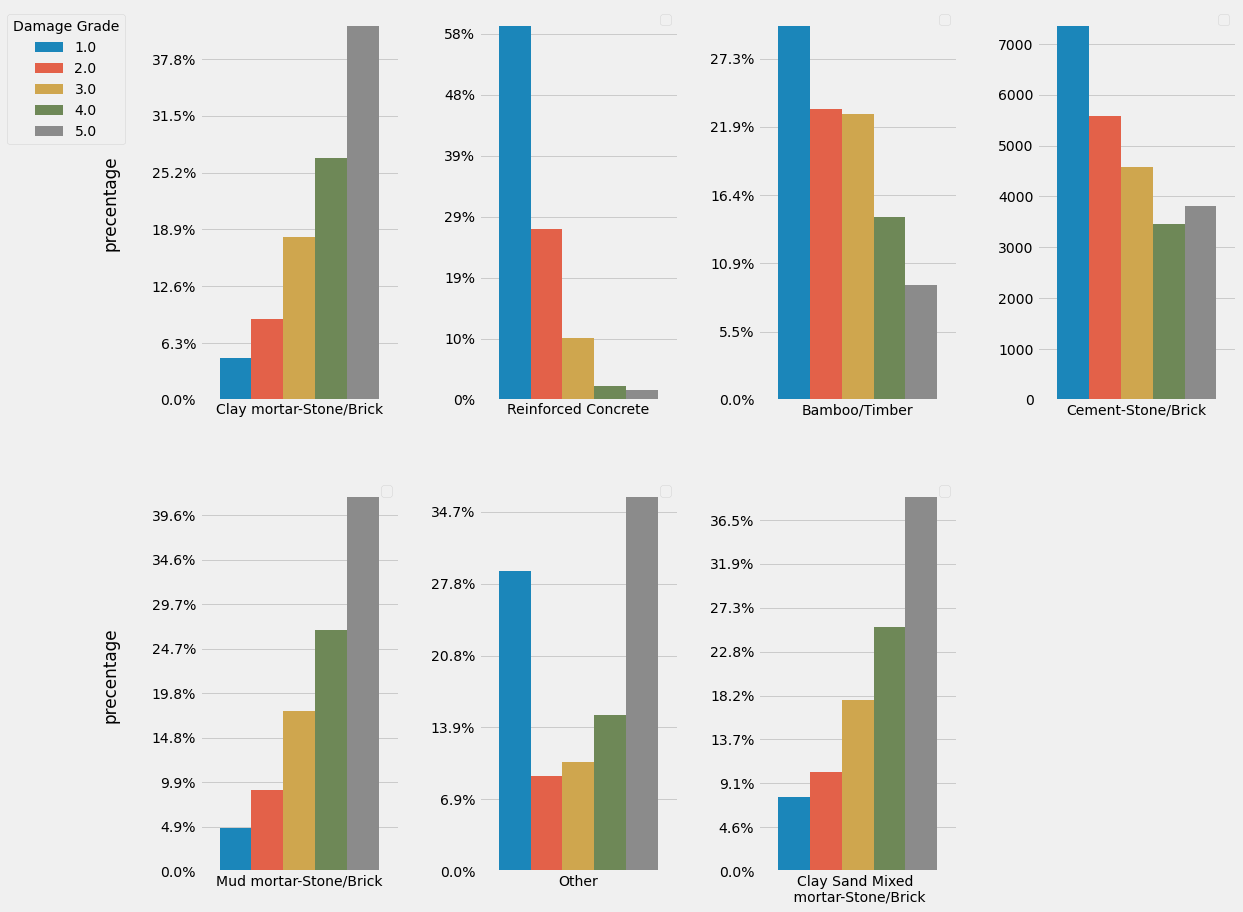

In [ ]:
import matplotlib.ticker as mtick

plt.figure(figsize=(18,15))
plt.style.use('fivethirtyeight')
plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.9,
                    top=0.9,
                    wspace=0.4,)

plt.subplot(2,4,1)
ax = sns.countplot(x=df_building_materials[df_building_materials['type_of_foundation'] == 'Clay mortar-Stone/Brick']['type_of_foundation'], hue=df_building_materials[df_building_materials['type_of_foundation'] == 'Clay mortar-Stone/Brick']['damage_grade'])
plt.legend(loc='upper left', bbox_to_anchor=(-1,1), title='Damage Grade')
ax.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=len(df_building_materials[df_building_materials['type_of_foundation'] == 'Clay mortar-Stone/Brick'])))
plt.xlabel('')
plt.ylabel('precentage')
ax.yaxis.set_label_coords(-0.4,0.5)

plt.subplot(2,4,2)
ax = sns.countplot(x=df_building_materials[df_building_materials['type_of_foundation'] == 'Reinforced Concrete']['type_of_foundation'], hue=df_building_materials[df_building_materials['type_of_foundation'] == 'Reinforced Concrete']['damage_grade'])
plt.legend('')
ax.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=len(df_building_materials[df_building_materials['type_of_foundation'] == 'Reinforced Concrete'])))
plt.xlabel('')
plt.ylabel('')

plt.subplot(2,4,3)
ax = sns.countplot(x=df_building_materials[df_building_materials['type_of_foundation'] == 'Bamboo/Timber']['type_of_foundation'], hue=df_building_materials[df_building_materials['type_of_foundation'] == 'Bamboo/Timber']['damage_grade'])
plt.legend('')
ax.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=len(df_building_materials[df_building_materials['type_of_foundation'] == 'Bamboo/Timber'])))
plt.xlabel('')
plt.ylabel('')

plt.subplot(2,4,4)
ax = sns.countplot(x=df_building_materials[df_building_materials['type_of_foundation'] == 'Cement-Stone/Brick']['type_of_foundation'], hue=df_building_materials[df_building_materials['type_of_foundation'] == 'Cement-Stone/Brick']['damage_grade'])
plt.legend('')
plt.xlabel('')
plt.ylabel('')


plt.subplot(2,4,5)
ax = sns.countplot(x=df_building_materials[df_building_materials['type_of_foundation'] == 'Mud mortar-Stone/Brick']['type_of_foundation'], hue=df_building_materials[df_building_materials['type_of_foundation'] == 'Mud mortar-Stone/Brick']['damage_grade'])
plt.legend('')
ax.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=len(df_building_materials[df_building_materials['type_of_foundation'] == 'Mud mortar-Stone/Brick'])))
plt.xlabel('')
plt.ylabel('precentage')
ax.yaxis.set_label_coords(-0.4,0.5)

plt.subplot(2,4,6)
ax = sns.countplot(x=df_building_materials[df_building_materials['type_of_foundation'] == 'Other']['type_of_foundation'], hue=df_building_materials[df_building_materials['type_of_foundation'] == 'Other']['damage_grade'])
plt.legend('')
ax.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=len(df_building_materials[df_building_materials['type_of_foundation'] == 'Other'])))
plt.xlabel('')
plt.ylabel('')

plt.subplot(2,4,7)
ax = sns.countplot(x=df_building_materials[df_building_materials['type_of_foundation'] == 'Clay Sand Mixed mortar-Stone/Brick']['type_of_foundation'], hue=df_building_materials[df_building_materials['type_of_foundation'] == 'Clay Sand Mixed mortar-Stone/Brick']['damage_grade'])
plt.legend('')
ax.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=len(df_building_materials[df_building_materials['type_of_foundation'] == 'Clay Sand Mixed mortar-Stone/Brick'])))
plt.xlabel('')
plt.ylabel('')
plt.xticks(ticks=[0],labels=['Clay Sand Mixed \n mortar-Stone/Brick'])


Dari visualisasi tersebut dapat disimpulkan bahwa material yang aman untuk dijadikan pondasi bangunan adalah Reinforced Concrete, Bamboo/Timber, dan Cement-Stone/Brick

In [ ]:
df_building_materials['type_of_ground_floor'].unique()

array(['Clay', 'Mud', 'Brick/Stone', 'Reinforced Concrete',
       'soil, water, loam Mixed', 'Other', 'Lumber', 'Timber', 'Wood'],
      dtype=object)